# **Data Mining Notebook**

## **1. Introduction**

Basic imports used thoughout the codebase. More specific imports such as regression model trainers are imported at the time of use.

In [109]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## **2. Data Import**

The 5 .csv files underneath ORIGINAL_MATCH_HISTORY correspond to 5 new datasets we generate throughout execution. Please **do not** change the paths for these additional files.

In [158]:
ORIGINAL_MATCH_HISTORY = '../dataset/match_history.csv'
RECONSTRUCTED_MATCH_HISTORY = '../dataset/reconstructed_match_history.csv'

INTERPOLATED_MATCH_HISTORY = '../dataset/reconstructed/interpolated_match_history.csv'
LINEAR_REGRESSION_MATCH_HISTORY = '../dataset/reconstructed/linear_regression_match_history.csv'
NEW_FEATURES_INTERPOLATED_MATCH_HISTORY = '../dataset/reconstructed/new_features_interpolated_match_history.csv'
NEW_FEATURES_LINEAR_REGRESSION_MATCH_HISTORY = '../dataset/reconstructed/new_features_linear_regression_match_history.csv'
NEW_FEATURES_GAUSSIAN_MATCH_HISTORY = '../dataset/reconstructed/new_features_gaussian_match_history.csv'

Showing the original dataset.

In [159]:
train_dataset = ORIGINAL_MATCH_HISTORY
df = pd.read_csv(train_dataset)
df

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,1,...,No,Draw,78.0,NaN,78.0,81.0,78.0,NaN,79.3,70.8
5637,2021-12-08,Mexico,Chile,North America,South America,14,24,1638,1541,2,...,No,Draw,80.0,79.0,76.8,82.7,78.2,75.5,76.7,78.2
5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,2,...,Yes,Lose,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0
5639,2021-12-18,Tunisia,Algeria,Africa,Africa,29,32,1512,1508,0,...,No,Lose,NaN,78.0,70.8,72.3,74.0,78.0,81.0,78.0


## **3. Data Transformation & Exploration**

### 3.1 Data Exploration of the Four Main Key Features

The following code produces four different graphs to visualise the key features in the dataset. It plots each of these features against FIFA rank, illustrating the general upward trend of teams performing better in all aspects the better their FIFA rank is.

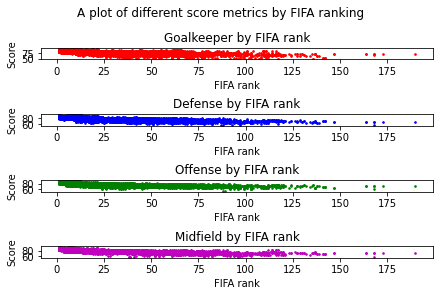

In [160]:
HOME_FEATURE_INDEXES = [17, 19, 20, 21]
AWAY_FEATURE_INDEXES = [18, 22, 23, 24]
HOME_TEAM_FIFA_RANK = 5
AWAY_TEAM_FIFA_RANK = 6
PLOT_TITLES = ['Goalkeeper', 'Defense', 'Offense', 'Midfield']
PLOT_COLOURS = 'rbgm'


def plot_fifa_score(original_data: str) -> None:
    '''
    Pull data from the given csv and plot 4 graphs, different features from the dataset against FIFA rank.
    '''
    with open(original_data, encoding='utf-8') as csv_in_file:
        csv_reader = csv.reader(csv_in_file)
        next(csv_reader)

        ranks = []
        features = {'Goalkeeper': [], 'Defense': [], 'Offense': [], 'Midfield': []}

        for row in csv_reader:
            # Get the correct features from the dataset for both
            # the home and away team.
            home_features = [row[i] for i in HOME_FEATURE_INDEXES]
            away_features = [row[i] for i in AWAY_FEATURE_INDEXES]

            # Only append the data and rank of the corresponding team if the data points
            # are fully intact and have no missing features.
            if '' not in home_features and '' not in away_features:
                ranks.append(int(row[HOME_TEAM_FIFA_RANK]))
                ranks.append(int(row[AWAY_TEAM_FIFA_RANK]))
                for i, score in enumerate(PLOT_TITLES):
                    new_points = [float(home_features[i]), float(away_features[i])]
                    features[score].extend(new_points)

        # Plot all four graphs on the same figure, with seperate colours and titles.
        fig, axs = plt.subplots(4, 1, constrained_layout=True)
        fig.suptitle('A plot of different score metrics by FIFA ranking')

        plot_data = zip(PLOT_COLOURS, features.items())
        for i, (colour, (title, data)) in enumerate(plot_data):
            axs[i].scatter(ranks, data, s=10, c=colour, marker='.')
            axs[i].set_title(f'{title} by FIFA rank')
            axs[i].set_xlabel('FIFA rank')
            axs[i].set_ylabel('Score')

        plt.show()

plot_fifa_score(ORIGINAL_MATCH_HISTORY)

### 3.2 Linear Interpolation Reconstruction

The following code using Pandas' Series.interpolate() function to replace NaN values in the original dataset with linearly interpolated values, for each of the four features that have missing data.

In [161]:
def interpolote_missing_data(original_data: str) -> dict:
    '''Interpolate completely missing features using Pandas .interpolate()'''

    with open(original_data, encoding='utf-8') as csv_in_file:
        csv_reader = csv.reader(csv_in_file)
        next(csv_reader)

        features = {'Goalkeeper': [], 'Defense': [], 'Offense': [], 'Midfield': []}
        interpolated_features = {'Goalkeeper': [], 'Defense': [], 'Offense': [], 'Midfield': []}

        for row in csv_reader:
            # Get the correct features from the dataset for both
            # the home and away team
            home_features = [row[i] for i in HOME_FEATURE_INDEXES]
            away_features = [row[i] for i in AWAY_FEATURE_INDEXES]
            
            # Append a tuple of (FIFA rank, value) to the feature dictionary for each type of score,
            # where the value is replace with a NumPy NaN value if it is missing
            for i, score in enumerate(PLOT_TITLES):
                home_val = np.nan if home_features[i] == '' else home_features[i]
                away_val = np.nan if away_features[i] == '' else away_features[i]
                features[score].append((int(row[HOME_TEAM_FIFA_RANK]), (home_val)))
                features[score].append((int(row[AWAY_TEAM_FIFA_RANK]), (away_val)))

        # For each different score type, order the list in the dictionary by FIFA rank, create a
        # pandas Series using the values, and replace the NaN values through linear interpolation.
        # Insert these new values into a new dictionary and return 
        for i, score in enumerate(PLOT_TITLES):
            sorted_score = [float(s) for (_, s) in sorted(features[score], key=lambda x: x[0])]
            interpolated_features[score] = list(pd.Series(sorted_score).interpolate())
    return interpolated_features

In [162]:
def get_averages(original_data: str) -> dict:
    '''
    Find average values for each 4 features for each country.
    '''

    countries = {}

    with open(original_data, encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)
        count = 0
        
        # For each row in the original match_history.csv file, loop over all of the rows
        # and keep a running total of each of the 4 scores in PLOT_TITLES, for each country, along
        # with the number of times that that feature was seen for said country (since sometimes
        # they are missing) and insert the values into a dictionary.
        for row in csv_reader:
            if '' in row:
                count += 1
            home_country, away_country = row[1], row[2]
            home_features = [row[i] for i in HOME_FEATURE_INDEXES]
            away_features = [row[i] for i in AWAY_FEATURE_INDEXES]

            if home_country not in countries.keys():
                countries[home_country] = [[0, 0], [0, 0], [0, 0], [0, 0]]
            if away_country not in countries.keys():
                countries[away_country] = [[0, 0], [0, 0], [0, 0], [0, 0]]

            for i, val in enumerate(home_features):
                if val != '':
                    countries[home_country][i][0] += float(val)
                    countries[home_country][i][1] += 1

            for i, val in enumerate(away_features):
                if val != '':
                    countries[away_country][i][0] += float(val)
                    countries[away_country][i][1] += 1
        
        # For each country in the dictionary, replace the list of score totals and counts with
        # their corresponding calculated averages and return.
        for country, vals in countries.items():
            averages = [round(val / max(1, count), 1) for [val, count] in vals]
            countries[country] = averages
        # Show which countries have at least one feature completely missing in the dataset
        for country, vals in countries.items():
            if 0.0 in vals:
                print(f'{country} has a completely missing value.')
    return countries

In [163]:
def write_interpolated_data(original_data: str, new_data: str, countries: dict) -> None:
    '''
    For each row in the input csv, write to the output csv filling in missisng
    values, with that countries average for that feature.
    '''

    with open(original_data, encoding='utf-8') as csv_in, open(new_data, 'w+', encoding='utf-8') as csv_out:
        csv_reader = csv.reader(csv_in)
        csv_writer = csv.writer(csv_out)
        csv_writer.writerow(next(csv_reader))
        
        # Gather interpolated data 
        interpolated_features = interpolote_missing_data(original_data)
        
        # For each row in the original match_history.csv file, loop over all of the records.
        # If any record has a value missing value, check whether the corresponding country has an average
        # for the missing feature. If so, replace the missing data with that average, if not, replace it
        # with the interpolated value. Finally, write the updated data into a new .csv file.
        for row in csv_reader:
            for i, val in enumerate(row):
                if val == '':
                    if i in HOME_FEATURE_INDEXES:
                        replace_index = HOME_FEATURE_INDEXES.index(i)
                        if countries[row[1]][replace_index] == 0.0:
                            score_type = PLOT_TITLES[replace_index]
                            row[i] = round(interpolated_features[score_type][int(row[HOME_TEAM_FIFA_RANK])], 1)
                        else:
                            row[i] = countries[row[1]][replace_index]

                    elif i in AWAY_FEATURE_INDEXES:
                        replace_index = AWAY_FEATURE_INDEXES.index(i)
                        if countries[row[2]][replace_index] == 0.0:
                            score_type = PLOT_TITLES[replace_index]
                            row[i] = round(interpolated_features[score_type][int(row[AWAY_TEAM_FIFA_RANK])], 1)
                        else:
                            row[i] = countries[row[2]][replace_index]
            csv_writer.writerow(row)

In [164]:
def reconstruct_with_interpolation(original_data: str, new_data: str) -> None:
    '''
    Reconstruct the missing data in original_data, write to new new_data csv.
    '''

    countries = get_averages(original_data)
    write_interpolated_data(original_data, new_data, countries)

    
# Reconstruct the missing data with linear interpolation and show the results
# Note that home_team_total_fifa_points and away_team_total_fifa_points are not 
# included in this reconstruction, because they are not being used in our regresion models
reconstruct_with_interpolation(ORIGINAL_MATCH_HISTORY, INTERPOLATED_MATCH_HISTORY)
df = pd.read_csv(INTERPOLATED_MATCH_HISTORY)
df

Zambia has a completely missing value.
Sierra Leone has a completely missing value.
Zimbabwe has a completely missing value.
Malta has a completely missing value.
Barbados has a completely missing value.
Armenia has a completely missing value.
Oman has a completely missing value.
Central African Republic has a completely missing value.
Kenya has a completely missing value.
Jordan has a completely missing value.
Iraq has a completely missing value.
Luxembourg has a completely missing value.
Azerbaijan has a completely missing value.
Suriname has a completely missing value.
Comoros has a completely missing value.
Uganda has a completely missing value.
Madagascar has a completely missing value.


,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,71.9,90.0,72.4,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,77.7,79.5,85.0,81.5,74.2,81.7,65.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,1,...,No,Draw,78.0,70.9,78.0,81.0,78.0,70.5,79.3,70.8
5637,2021-12-08,Mexico,Chile,North America,South America,14,24,1638,1541,2,...,No,Draw,80.0,79.0,76.8,82.7,78.2,75.5,76.7,78.2
5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,2,...,Yes,Lose,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0
5639,2021-12-18,Tunisia,Algeria,Africa,Africa,29,32,1512,1508,0,...,No,Lose,64.0,78.0,70.8,72.3,74.0,78.0,81.0,78.0


### 3.3 Linear Regression Reconstruction

#### Data Preparation

In [165]:
HOME_FEATURE_INDEXES = [9, 17, 19, 20, 21]
AWAY_FEATURE_INDEXES = [10, 18, 22, 23, 24]
HOME_TEAM_FIFA_RANK = 5
AWAY_TEAM_FIFA_RANK = 6

def fetch_data(original_data: str) -> []:
    '''
    Pull data from the given csv and plot 5 graphs, of score, offense score,
    defense score, midfield score and goalkeeper score against FIFA rank.
    '''
    result = []
    
    with open(original_data, encoding='utf-8') as csv_in_file:
        csv_reader = csv.reader(csv_in_file)
        next(csv_reader) # Skip the column headers

        ranks = []
        # features = [scores, gk_scores, def_scores, off_scores, mid_scores]
        features = [[], [], [], [], []]

        for row in csv_reader:
            # Extract the 5 types of score from the given csv for
            home_features = [row[i] for i in HOME_FEATURE_INDEXES]
            away_features = [row[i] for i in AWAY_FEATURE_INDEXES]

            # Only append the data to the lists is it is fully intact
            if '' not in home_features and '' not in away_features:
                ranks.append(int(row[HOME_TEAM_FIFA_RANK]))
                ranks.append(int(row[AWAY_TEAM_FIFA_RANK]))
                for i in range(5):
                    features[i].append(float(home_features[i]))
                    features[i].append(float(away_features[i]))
        
        result.append(ranks)
        result.append(features)
        
        return result

In [166]:
def linear_get_averages(original_data: str) -> dict:
    '''
    Find average values for each 5 features for each country.
    '''

    countries = {}

    with open(original_data, encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)

        for row in csv_reader:
            home_country, away_country = row[1], row[2]
            home_features = [row[i] for i in HOME_FEATURE_INDEXES]
            away_features = [row[i] for i in AWAY_FEATURE_INDEXES]

            if home_country not in countries.keys():
                countries[home_country] = [[0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0]]
            if away_country not in countries.keys():
                countries[away_country] = [[0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0], [0.0, 0]]

            for i, val in enumerate(home_features):
                if val != '':
                    countries[home_country][i][0] += float(val)
                    countries[home_country][i][1] += 1

            for i, val in enumerate(away_features):
                if val != '':
                    countries[away_country][i][0] += float(val)
                    countries[away_country][i][1] += 1

        for country, value_list in countries.items():
            countries[country] = [round(val / max(1, count), 1) for [val, count] in value_list]

    return countries
    

In [167]:
def linear_write_missing_data(original_data: str, reconstructed_data: str,
                        countries: dict) -> None:
    '''
    For each row in the input csv, write to the output csv filling in missisng
    values, with that countries average for that feature.
    '''

    with open(original_data, encoding='utf-8') as csv_in_file, open(reconstructed_data, 'w', encoding='utf-8') as csv_out_file:
        csv_reader = csv.reader(csv_in_file)
        csv_writer = csv.writer(csv_out_file)
        csv_writer.writerow(next(csv_reader))

        for row in csv_reader:
            for i, val in enumerate(row):
                if val == '':
                    if i in HOME_FEATURE_INDEXES:
                        replace_index = HOME_FEATURE_INDEXES.index(i)
                        row[i] = countries[row[1]][replace_index]
                    elif i in AWAY_FEATURE_INDEXES:
                        replace_index = AWAY_FEATURE_INDEXES.index(i)
                        row[i] = countries[row[2]][replace_index]
            csv_writer.writerow(row)
    

In [168]:
def linear_reconstruct(original_data: str, reconstructed_data: str) -> None:
    '''
    Reconstruct the missing data in original_data and write to new
    reconstructed_data csv.
    '''

    countries = linear_get_averages(original_data)
    linear_write_missing_data(original_data, reconstructed_data, countries)

In [169]:
data = fetch_data(ORIGINAL_MATCH_HISTORY)
linear_reconstruct(ORIGINAL_MATCH_HISTORY, RECONSTRUCTED_MATCH_HISTORY)

linear_reconstruct(ORIGINAL_MATCH_HISTORY, LINEAR_REGRESSION_MATCH_HISTORY)
df = pd.read_csv(INTERPOLATED_MATCH_HISTORY)
df

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,71.9,90.0,72.4,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,77.7,79.5,85.0,81.5,74.2,81.7,65.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,2021-12-07,Algeria,Egypt,Africa,Africa,32,45,1508,1449,1,...,No,Draw,78.0,70.9,78.0,81.0,78.0,70.5,79.3,70.8
5637,2021-12-08,Mexico,Chile,North America,South America,14,24,1638,1541,2,...,No,Draw,80.0,79.0,76.8,82.7,78.2,75.5,76.7,78.2
5638,2021-12-11,Morocco,Algeria,Africa,Africa,28,32,1525,1508,2,...,Yes,Lose,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0
5639,2021-12-18,Tunisia,Algeria,Africa,Africa,29,32,1512,1508,0,...,No,Lose,64.0,78.0,70.8,72.3,74.0,78.0,81.0,78.0


In [170]:
import numpy as np
import pandas as pd

d = {'gk_score': [],
     'def_score': [],
     'mid_score': [],
     'atk_score': [],
    }

for i in range(8232):
    d['gk_score'].append([data[0][i],data[1][1][i]])
    d['def_score'].append([data[0][i],data[1][2][i]])
    d['mid_score'].append([data[0][i],data[1][3][i]])
    d['atk_score'].append([data[0][i],data[1][4][i]])

    
d['gk_score'] = np.array(d['gk_score']).astype(float)
d['def_score'] = np.array(d['def_score']).astype(float)
d['atk_score'] = np.array(d['atk_score']).astype(float)
d['mid_score'] = np.array(d['mid_score']).astype(float)

#### Construct Linear Model using FIFA rank and position score features

Score: 0.33987625660544685


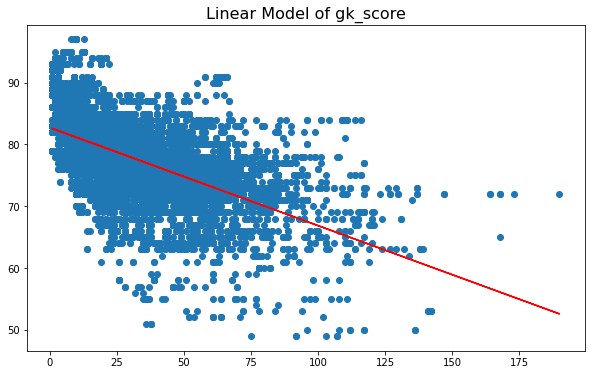

Score: 0.4566411420539599


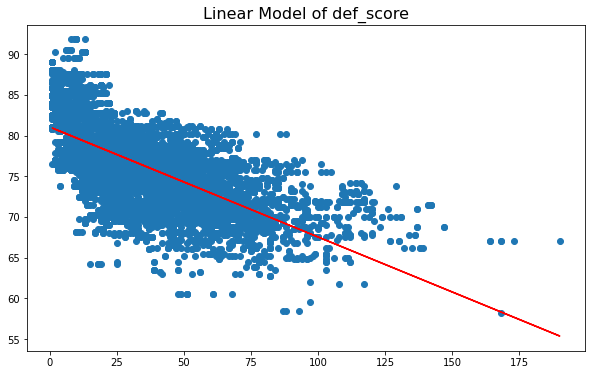

Score: 0.453174243928145


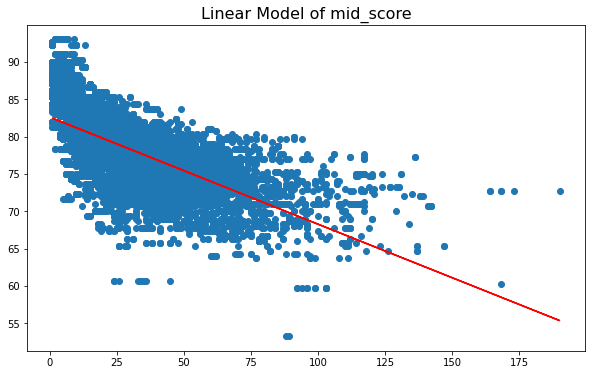

Score: 0.4893148508181151


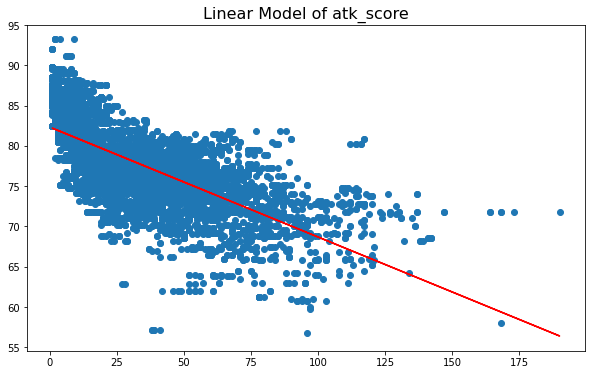

In [171]:
def lr_model(model_data, pos_score):
    d = np.hsplit(model_data,2)
    rank = d[0]
    pos = d[1]
    
    train_input, test_input, train_target, test_target = train_test_split(
    rank, pos, random_state=42)
    
    lr = LinearRegression()

    lr.fit(train_input, train_target)
    print("Score: {}".format(lr.score(test_input, test_target)))
    
    y_predicted = lr.predict(rank)
    plt.figure(figsize=(10, 6))
    plt.title("Linear Model of {}".format(pos_score), size=16)
    plt.scatter(rank, pos)
    plt.plot(rank, y_predicted, c="red")
    plt.show()
    
    return lr

lr_gk = lr_model(d['gk_score'],'gk_score')
lr_def = lr_model(d['def_score'],'def_score')
lr_mid = lr_model(d['mid_score'],'mid_score')
lr_atk = lr_model(d['atk_score'],'atk_score')

In [172]:
d_f = pd.read_csv(RECONSTRUCTED_MATCH_HISTORY)

#extract following columns
core_df = d_f[[
    "date", 
    "home_team", "away_team", 
    "home_team_fifa_rank", "away_team_fifa_rank",  
    'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
    'home_team_mean_defense_score', 'home_team_mean_offense_score',
    'home_team_mean_midfield_score', 'away_team_mean_defense_score',
    'away_team_mean_offense_score', 'away_team_mean_midfield_score',
    'home_team_result',
    ]].copy()

#simple data modification
core_df = core_df.fillna(0)
core_df["home_team_result"] = core_df["home_team_result"].replace(['Lose', 'Draw', 'Win'], [-1, 0, 1])
core_df['date'] = core_df['date'].str.replace(r"\D", "", regex=True)


#variables 
home_score = [
    'home_team_goalkeeper_score', 
    'home_team_mean_defense_score', 
    'home_team_mean_offense_score',
    'home_team_mean_midfield_score',
]

away_score = [
    'away_team_goalkeeper_score',
    'away_team_mean_defense_score',
    'away_team_mean_offense_score', 
    'away_team_mean_midfield_score',
]

#country = np.unique(country_name, return_counts=True)
country_list = df['home_team'].values
country_list = np.unique(country_list)

pos_score = [
    'gk_score',
    'def_score',
    'mid_score',
    'atk_score'
    ]

core_df

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_team_result
0,20040903,Spain,Scotland,3,67,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8,0
1,20040904,Albania,Greece,94,14,71.9,90.0,72.4,59.0,74.5,82.8,83.7,85.2,1
2,20040904,Austria,England,90,7,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2,0
3,20040904,Croatia,Hungary,25,76,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2,1
4,20040904,Denmark,Ukraine,15,87,82.0,77.7,79.5,85.0,81.5,74.2,81.7,65.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,20211207,Algeria,Egypt,32,45,78.0,70.9,78.0,81.0,78.0,70.5,79.3,70.8,0
5637,20211208,Mexico,Chile,14,24,80.0,79.0,76.8,82.7,78.2,75.5,76.7,78.2,0
5638,20211211,Morocco,Algeria,28,32,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0,-1
5639,20211218,Tunisia,Algeria,29,32,64.0,78.0,70.8,72.3,74.0,78.0,81.0,78.0,-1


In [173]:
scores_rank = {}


for index, row in core_df.iterrows():
    home = row['home_team']
    away = row['away_team']
    
    if home not in scores_rank:
        scores_rank[home] = {}
        scores_rank[home]['gk_score'] = []
        scores_rank[home]['def_score'] = []
        scores_rank[home]['mid_score'] = []
        scores_rank[home]['atk_score'] = []
        
    if away not in scores_rank:
        scores_rank[away] = {}
        scores_rank[away]['gk_score'] = []
        scores_rank[away]['def_score'] = []
        scores_rank[away]['mid_score'] = []
        scores_rank[away]['atk_score'] = []
    
    scores_rank[home]['gk_score'].append([row['date'],row['home_team_fifa_rank'], row['home_team_goalkeeper_score']])
    scores_rank[home]['def_score'].append([row['date'],row['home_team_fifa_rank'], row['home_team_mean_defense_score']])
    scores_rank[home]['mid_score'].append([row['date'],row['home_team_fifa_rank'], row['home_team_mean_midfield_score']])
    scores_rank[home]['atk_score'].append([row['date'],row['home_team_fifa_rank'],row['home_team_mean_offense_score']])
    
    scores_rank[away]['gk_score'].append([row['date'], row['away_team_fifa_rank'], row['away_team_goalkeeper_score']])
    scores_rank[away]['def_score'].append([row['date'], row['away_team_fifa_rank'], row['away_team_mean_defense_score']])
    scores_rank[away]['mid_score'].append([row['date'], row['away_team_fifa_rank'], row['away_team_mean_midfield_score']])
    scores_rank[away]['atk_score'].append([row['date'], row['away_team_fifa_rank'],row['away_team_mean_offense_score']])

In [174]:
# fetch according country, position_team_mean_score from dict scores 
# Since Nan replaced with 0s, if 0 not included in the data, returns an empty list 
# => no missing values, no prediction needed
def fetch_country_pos_score_rank(country, pos_score):
    predict_target = []
    model_data = []
    
    for item in scores_rank[country][pos_score]:
        if 0 in item:
            predict_target.append(item)
        else:
            model_data.append(item)
            
    if predict_target == []:
        #print("No missing values")
        return []
            
    else:   
        data = [model_data, predict_target,country, pos_score]
        print(data)
        # model_data and predict_target to np float array
        data[0] = np.array(data[0]).astype(float)
        data[1] = np.array(data[1]).astype(float)

        return data

#d = fetch_country_pos_score('Albania','gk_score')
#d

#### Collecting Data of Countries with Missing Values without Model Data

In [175]:
def no_data_country_scores():
    targets = []
    
    for country in country_list:
        for score in pos_score:
            data = fetch_country_pos_score_rank(country, score)
            if data == []:
                continue
            model_data = data[0]
            
            if model_data.size == 0:
                targets.append("{} {}".format(country,score))
    
    return targets

In [176]:
target_scores = {}
target_keys = []
t = no_data_country_scores()

for elem in t:
    print(elem)
    sp = elem.split(" ")
    
    if len(sp) > 2:
        result = ' '.join(sp[:-1])
        sp = [result,sp[-1]]
    
    target_keys.append(sp)
    
    if sp[0] not in target_scores:
        target_scores[sp[0]] = {}
        
    if sp[1] not in target_scores[sp[0]]:
        target_scores[sp[0]][sp[1]] = []
        
    target_scores[sp[0]][sp[1]] = scores_rank[sp[0]][sp[1]]

[[], [['20120911', 53, 0.0], ['20121012', 64, 0.0], ['20130326', 84, 0.0], ['20130611', 89, 0.0], ['20130906', 66, 0.0], ['20130910', 66, 0.0], ['20131011', 55, 0.0], ['20131015', 55, 0.0], ['20140305', 30, 0.0], ['20140531', 33, 0.0], ['20140606', 38, 0.0], ['20160904', 102, 0.0], ['20161008', 112, 0.0], ['20161011', 112, 0.0], ['20161111', 125, 0.0], ['20170610', 68, 0.0], ['20170901', 72, 0.0], ['20170904', 72, 0.0], ['20171005', 83, 0.0], ['20190323', 101, 0.0], ['20190326', 101, 0.0], ['20190611', 106, 0.0], ['20210902', 88, 0.0], ['20210905', 88, 0.0], ['20211008', 89, 0.0], ['20211011', 89, 0.0], ['20211111', 89, 0.0], ['20211114', 89, 0.0]], 'Armenia', 'def_score']
[[], [['20161008', 133, 0.0], ['20161011', 133, 0.0], ['20161111', 88, 0.0], ['20170326', 89, 0.0], ['20170610', 76, 0.0]], 'Azerbaijan', 'def_score']
[[], [['20161008', 133, 0.0], ['20161011', 133, 0.0], ['20161111', 88, 0.0], ['20170326', 89, 0.0], ['20170610', 76, 0.0]], 'Azerbaijan', 'atk_score']
[[], [['20191012

#### Predict Missing Values without Model Data

In [177]:
def predict_scores_lr(data):
    #data[1] contains model_data which should be empty in these cases
    country = data[2]
    pos_score = data[3]
    
    if pos_score == 'gk_score':
        lr = lr_gk
    elif pos_score == 'def_score':
        lr = lr_def
    elif pos_score == 'mid_score':
        lr = lr_mid
    else:
        lr = lr_atk
        
    predict_target = data[1]
    
    d = np.hsplit(predict_target,3)

    d[2] = lr.predict(d[1])
    d[1] = np.array(d[1]).astype(int)

    complete_data = np.hstack(d).tolist()

    for elem in complete_data:
        elem[2] = float(elem[2])

    complete_data.append(country)
    complete_data.append(pos_score)

    return complete_data


#dd = fetch_country_pos_score('Armenia', 'def_score')
#predict_scores_lr(dd)

In [178]:
for elem in target_keys:
    country = elem[0]
    pos_score = elem[1]
    
    ccd = fetch_country_pos_score_rank(country, pos_score)
    target_scores[country][pos_score] = predict_scores_lr(ccd)

[[], [['20120911', 53, 0.0], ['20121012', 64, 0.0], ['20130326', 84, 0.0], ['20130611', 89, 0.0], ['20130906', 66, 0.0], ['20130910', 66, 0.0], ['20131011', 55, 0.0], ['20131015', 55, 0.0], ['20140305', 30, 0.0], ['20140531', 33, 0.0], ['20140606', 38, 0.0], ['20160904', 102, 0.0], ['20161008', 112, 0.0], ['20161011', 112, 0.0], ['20161111', 125, 0.0], ['20170610', 68, 0.0], ['20170901', 72, 0.0], ['20170904', 72, 0.0], ['20171005', 83, 0.0], ['20190323', 101, 0.0], ['20190326', 101, 0.0], ['20190611', 106, 0.0], ['20210902', 88, 0.0], ['20210905', 88, 0.0], ['20211008', 89, 0.0], ['20211011', 89, 0.0], ['20211111', 89, 0.0], ['20211114', 89, 0.0]], 'Armenia', 'def_score']
[[], [['20161008', 133, 0.0], ['20161011', 133, 0.0], ['20161111', 88, 0.0], ['20170326', 89, 0.0], ['20170610', 76, 0.0]], 'Azerbaijan', 'def_score']
[[], [['20161008', 133, 0.0], ['20161011', 133, 0.0], ['20161111', 88, 0.0], ['20170326', 89, 0.0], ['20170610', 76, 0.0]], 'Azerbaijan', 'atk_score']
[[], [['20191012

In [179]:
for country in target_scores:
    for score in target_scores[country]:
        target_scores[country][score].pop()
        target_scores[country][score].pop()
        
#print(target_scores)  

In [180]:
reconstructed_df = core_df

for country in target_scores:
    for score in target_scores[country]:
        for elem in target_scores[country][score]:
            date = str(int(elem[0]))
            row = reconstructed_df[(reconstructed_df['date'] == date) & ((reconstructed_df['home_team'] == country) | (reconstructed_df['away_team'] == country))]
            row_core = reconstructed_df[(reconstructed_df['date'] == date) & ((reconstructed_df['home_team'] == country) | (reconstructed_df['away_team'] == country))]
            i = reconstructed_df.index[(reconstructed_df['date'] == date) & ((reconstructed_df['home_team'] == country) | (reconstructed_df['away_team'] == country))].tolist()
            data = elem[2]
            c1 = ''
            c2 = ''
            if score == 'gk_score':
                c1 = 'home_team_goalkeeper_score'
                c2 = 'away_team_goalkeeper_score'
            elif score == 'def_score':
                c1 = 'home_team_mean_defense_score'
                c2 = 'away_team_mean_defense_score'
            elif score == 'mid_score':
                c1 = 'home_team_mean_midfield_score'
                c2 = 'away_team_mean_midfield_score'
            elif score == 'atk_score':
                c1 = 'home_team_mean_offense_score'
                c2 = 'away_team_mean_offense_score'
                
            
            if reconstructed_df.at[i[0],c1] == 0:
                reconstructed_df.at[i[0],c1] = data
            elif reconstructed_df.at[i[0],c2] == 0:
                reconstructed_df.at[i[0],c2] = data

reconstructed_df.to_csv(LINEAR_REGRESSION_MATCH_HISTORY, index=False)
reconstructed_df          

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_team_result
0,20040903,Spain,Scotland,3,67,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8,0
1,20040904,Albania,Greece,94,14,71.9,90.0,72.4,59.0,74.5,82.8,83.7,85.2,1
2,20040904,Austria,England,90,7,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2,0
3,20040904,Croatia,Hungary,25,76,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2,1
4,20040904,Denmark,Ukraine,15,87,82.0,77.7,79.5,85.0,81.5,74.2,81.7,65.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,20211207,Algeria,Egypt,32,45,78.0,70.9,78.0,81.0,78.0,70.5,79.3,70.8,0
5637,20211208,Mexico,Chile,14,24,80.0,79.0,76.8,82.7,78.2,75.5,76.7,78.2,0
5638,20211211,Morocco,Algeria,28,32,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0,-1
5639,20211218,Tunisia,Algeria,29,32,64.0,78.0,70.8,72.3,74.0,78.0,81.0,78.0,-1


### 3.4 Gaussian Distribution Reconstruction

#### Data Preparation

In [181]:
train_dataset = ORIGINAL_MATCH_HISTORY
g_df = pd.read_csv(train_dataset)

In [182]:
#Simple data modification
g_df = g_df.fillna(0)
g_df["home_team_result"] = g_df["home_team_result"].replace(['Lose', 'Draw', 'Win'], [0, 1, 2])
g_df["neutral_location"] = g_df["neutral_location"].astype(int)
g_df['date'] = g_df['date'].str.replace(r"\D", "", regex=True)

g_df

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,20040903,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,1,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,20040904,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,2,0.0,90.0,0.0,59.0,74.5,82.8,83.7,85.2
2,20040904,Austria,England,Europe,Europe,90,7,0,0,2,...,No,1,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,20040904,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,2,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,20040904,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,1,82.0,0.0,79.5,85.0,81.5,0.0,81.7,65.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,20211207,Algeria,Egypt,Africa,Africa,32,45,1508,1449,1,...,No,1,78.0,0.0,78.0,81.0,78.0,0.0,79.3,70.8
5637,20211208,Mexico,Chile,North America,South America,14,24,1638,1541,2,...,No,1,80.0,79.0,76.8,82.7,78.2,75.5,76.7,78.2
5638,20211211,Morocco,Algeria,Africa,Africa,28,32,1525,1508,2,...,Yes,0,82.0,78.0,81.2,81.7,76.2,78.0,81.0,78.0
5639,20211218,Tunisia,Algeria,Africa,Africa,29,32,1512,1508,0,...,No,0,0.0,78.0,70.8,72.3,74.0,78.0,81.0,78.0


In [183]:
#Define variables for later use
home_score = [
    'home_team_goalkeeper_score', 
    'home_team_mean_defense_score', 
    'home_team_mean_offense_score',
    'home_team_mean_midfield_score',
]

away_score = [
    'away_team_goalkeeper_score',
    'away_team_mean_defense_score',
    'away_team_mean_offense_score', 
    'away_team_mean_midfield_score',
]

#country = np.unique(country_name, return_counts=True)
country_list = g_df['home_team'].values
country_list = np.unique(country_list)

pos_score = [
    'gk_score',
    'def_score',
    'mid_score',
    'atk_score'
    ]

In [184]:
#Construct dictionary for later use

scores = {}

for index, row in g_df.iterrows():
    home = row['home_team']
    away = row['away_team']
    
    if home not in scores:
        scores[home] = {}
        scores[home]['gk_score'] = []
        scores[home]['def_score'] = []
        scores[home]['mid_score'] = []
        scores[home]['atk_score'] = []
        
    if away not in scores:
        scores[away] = {}
        scores[away]['gk_score'] = []
        scores[away]['def_score'] = []
        scores[away]['mid_score'] = []
        scores[away]['atk_score'] = []
    
    scores[home]['gk_score'].append([row['date'], row['home_team_goalkeeper_score']])
    scores[home]['def_score'].append([row['date'], row['home_team_mean_defense_score']])
    scores[home]['mid_score'].append([row['date'], row['home_team_mean_midfield_score']])
    scores[home]['atk_score'].append([row['date'],row['home_team_mean_offense_score']])
    
    scores[away]['gk_score'].append([row['date'], row['away_team_goalkeeper_score']])
    scores[away]['def_score'].append([row['date'], row['away_team_mean_defense_score']])
    scores[away]['mid_score'].append([row['date'], row['away_team_mean_midfield_score']])
    scores[away]['atk_score'].append([row['date'],row['away_team_mean_offense_score']])
    

#### Utility Functions

In [185]:
# fetch according country, position_team_mean_score from dict scores 
# if 0 not included in the data, returns an empty list => no missing values, no prediction needed
def fetch_country_pos_score(country, pos_score):
    predict_target = []
    model_data = []
    
    for item in scores[country][pos_score]:
        if 0 in item:
            predict_target.append(item)
        else:
            model_data.append(item)
            
    if predict_target == []:
        #print("No missing values")
        return []
            
    else:
        #if model_data == []:
            #print("No data available")
        #else:
            #print("Missing", len(predict_target), "values")   
        
        data = [model_data, predict_target]

        # model_data and predict_target to np float array
        data[0] = np.array(data[0]).astype(float)
        data[1] = np.array(data[1]).astype(float)

        return data

#fetch_country_pos_score('Albania','gk_score')

In [186]:
def fetch_country_score(country):
    data = []
    
    #index 0: gk, index 1: def, index 2: mid, index 3: atk
    for score in pos_score:
        #print(score,": ",end = "")
        data.append(fetch_country_pos_score(country,score))
    
    return data

#fetch_country_score('Albania')

#### Displaying Data

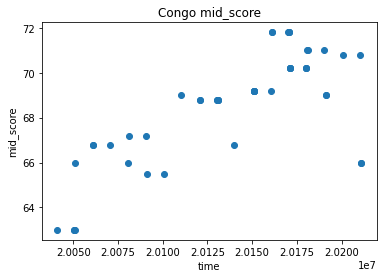

In [187]:
import matplotlib.pyplot as plt

total_graphs = []
# plot data based on country and pos_score info
def show_model_data(country, pos_score):
    data = fetch_country_pos_score(country, pos_score)
    
    # don't draw graph if there is no data to draw
    if data == [] or len(data[0]) == 0:
        return
    else:
        total_graphs.append("{} {}".format(country,pos_score))
        model_data = data[0]
        d = np.hsplit(model_data,2)
        plt.scatter(d[0],d[1])
        plt.xlabel('time')
        plt.ylabel(pos_score)
        plt.title("{} {}".format(country,pos_score))
        plt.show()

show_model_data('Congo','mid_score')
#show_model_data('Azerbaijan', 'def_score')

-------------------------------
Albania Position Scores
-------------------------------


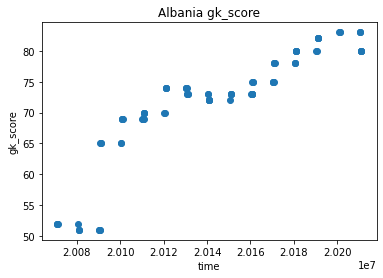

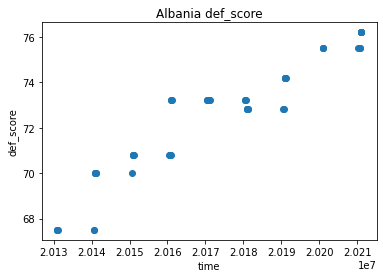

In [188]:
# displays the variables that needs to be investigated to generate missing values
# so for Albania case, gk and def scores contain missing values => target for prediction
def show_model_data_country(country):
    print("-------------------------------")
    print(country, "Position Scores")
    print("-------------------------------")

    count = 0
    data = fetch_country_score(country)
    
    for elem in data:
        count += 1
        # again, don't display graph if there is no data
        if elem == [] or len(elem[0]) == 0:
            pass
        else:
            model_data = elem[0]
            d = np.hsplit(model_data,2)
            plt.scatter(d[0],d[1])
            plt.xlabel('time')
            if count == 1:
                plt.title("{} {}".format(country,'gk_score'))
                plt.ylabel('gk_score')
            elif count == 2:
                plt.title("{} {}".format(country,'def_score'))
                plt.ylabel('def_score')
            elif count == 3:
                plt.title("{} {}".format(country,'mid_score'))
                plt.ylabel('mid_score')
            else:
                plt.title("{} {}".format(country,'atk_score'))
                plt.ylabel('atk_score')
            plt.show()

show_model_data_country('Albania')
#show_model_data('Congo')
#show_model_data('Azerbaijan')

#### Gaussian Method

##### Calculation

In [189]:
import scipy.stats as stats
from statistics import mean
from scipy.stats import truncnorm

#translates from sample to sd space given a distribution's mean and sd
def sample_to_sd(sample, mean, sd):
    return (sample - mean) / sd

# use truncated gaussian bounded at lower and upper limits
def generate_truncated_gaussian(params):
    mean = params[0]
    sd = params[1]
    lower = params[2]
    upper = params[3]

    return truncnorm(sample_to_sd(lower, mean, sd), sample_to_sd(upper, mean, sd), loc= mean, scale = sd)

In [190]:
#calculates necessary parameters on given data
def get_gaussian_parameters(data):
    # average data for each score
    avg = np.mean(data[0], axis=0)[1]
    #avdef = np.mean(fetch_country_pos_score('Albania','def_score')[0], axis=0)[1]

    # variance data for each scores for Albania
    var= np.var(data[0], axis=0)[1]
    sd = np.sqrt(var)
    #vardef= np.var(fetch_country_pos_score('Albania','def_score')[0], axis=0)[1]

    #min and max to truncate gaussian
    min = np.amin(data[0], axis=0)[1]
    max = np.amax(data[0], axis=0)[1]

    return [avg, sd, min, max]

##### Sampling

In [191]:
#samples from a generated gaussian distribution
def sample_truncated_gaussian(data):
    params = get_gaussian_parameters(data)
    dist = generate_truncated_gaussian(params)

    if isinstance(dist, int):
        return dist

    return dist.rvs(1)[0]

In [192]:
#gathers position score data and samples gaussian distribution to simulate it
def fetch_gaussian_pos_score(country, pos_score):
    data = fetch_country_pos_score(country, pos_score)
    #in this case there is no data at all for the position score; use the median score 75
    if len(data[0]) == 0:
        return 75.0

    #subroutine to check if all data values are the same (invalid variance)
    sum = 0
    ln = len(data[0])
    for i in range(ln):
        sum += data[0][i][1]
    if sum/ln == data[0][0][1]:
        return data[0][0][1]

    return sample_truncated_gaussian(data)

fetch_gaussian_pos_score('Honduras', 'gk_score')

61.0

##### Visualisation

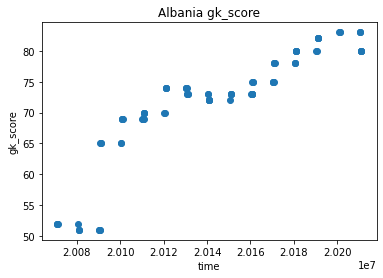

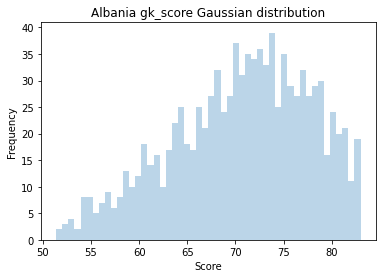

true mean =  71.85858585858585
standard deviation =  8.87171205393191
min =  51.0
max =  83.0


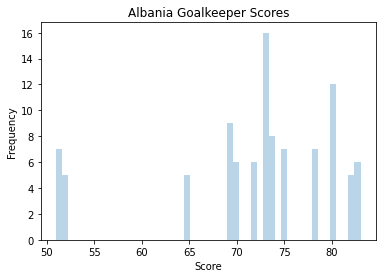

In [193]:
show_model_data('Albania', 'gk_score')

# gaussian distribution for country, pos_score
def show_gaussian_pos_score(country, pos_score):
    data = fetch_country_pos_score(country, pos_score)
    params = get_gaussian_parameters(data)

    X = generate_truncated_gaussian(params)
    plt.hist(X.rvs(1000), bins= 50, alpha=0.3)
    plt.title("{} {} Gaussian distribution".format(country, pos_score))
    #plt.title("Albania Goalkeeper Score Gaussian Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

    print("true mean = ", params[0])
    print("standard deviation = ", params[1])
    print("min = ", params[2])
    print("max = ", params[3])

#show_gaussian_pos_score('Congo', 'gk_score')
show_gaussian_pos_score('Albania', 'gk_score')

#now creating a box plot for direct comparison with the distribution
data = fetch_country_pos_score('Albania', 'gk_score')
data_scores = np.split(data[0], 2, axis=1)
box_scores = []
for item in data_scores[1]:
    box_scores.append(item[0])


plt.hist(box_scores, bins= 50, alpha=0.3)
plt.title("Albania Goalkeeper Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

##### Reconstruction

In [194]:
#fills in missing position scores for a single record
def fill_record_pos_scores(record):
    #countries in this record
    home = record['home_team']
    away = record['away_team']

    features = [
    'home_team_goalkeeper_score',
    'away_team_goalkeeper_score',
    'home_team_mean_defense_score',
    'away_team_mean_defense_score',
    'home_team_mean_offense_score',
    'away_team_mean_offense_score',
    'home_team_mean_midfield_score',
    'away_team_mean_midfield_score',
    ]

    #dictionary to check if a value corresponds to home or away team, and give the position
    check = {
    'home_team_goalkeeper_score':[1, 'gk_score'],
    'away_team_goalkeeper_score':[0, 'gk_score'],
    'home_team_mean_defense_score':[1, 'def_score'],
    'away_team_mean_defense_score':[0, 'def_score'],
    'home_team_mean_offense_score':[1, 'atk_score'],
    'away_team_mean_offense_score':[0, 'atk_score'],
    'home_team_mean_midfield_score':[1, 'mid_score'],
    'away_team_mean_midfield_score':[0, 'mid_score']
    }

    for feature in features:
        if record[feature] == 0:
            country = home
            if check[feature][0] == 0: 
                country = away
            position = check[feature][1]

            val = fetch_gaussian_pos_score(country, position)
            record[feature] = val

In [195]:
#fill all records
def fill_df_pos_scores(df):
    for index, record in df.iterrows():
        fill_record_pos_scores(record)

fill_df_pos_scores(g_df)

### 3.5 Box Plot Visualisation

In [196]:
def gather_position_scores(df):
    #array of scores for each position:
    #goalkeeper, defense, attack, midfield

    pos_scores = [[], [], [], []]

    features = [
    'home_team_goalkeeper_score',
    'away_team_goalkeeper_score',
    'home_team_mean_defense_score',
    'away_team_mean_defense_score',
    'home_team_mean_offense_score',
    'away_team_mean_offense_score',
    'home_team_mean_midfield_score',
    'away_team_mean_midfield_score',
    ]

    #dictionary to check what index feature corresponds to in pos_scores array
    check = {
    'home_team_goalkeeper_score':0,
    'away_team_goalkeeper_score':0,
    'home_team_mean_defense_score':1,
    'away_team_mean_defense_score':1,
    'home_team_mean_offense_score':2,
    'away_team_mean_offense_score':2,
    'home_team_mean_midfield_score':3,
    'away_team_mean_midfield_score':3
    }

    for index, record in df.iterrows():
        for feature in features:
            if record[feature]:
                pos_scores[check[feature]].append(record[feature])

    return pos_scores

In [197]:
def draw_box_plot(data, title):
    plt.boxplot(data)
    plt.title(title)
    plt.show()

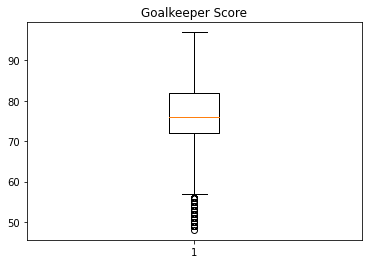

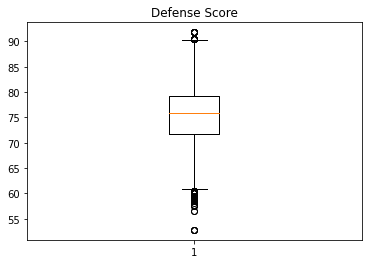

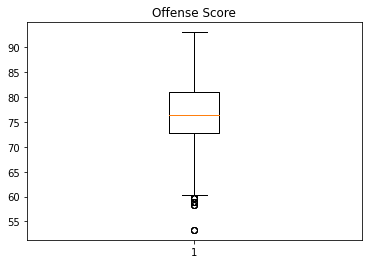

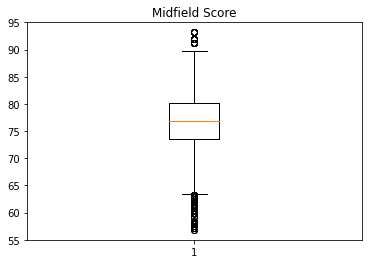

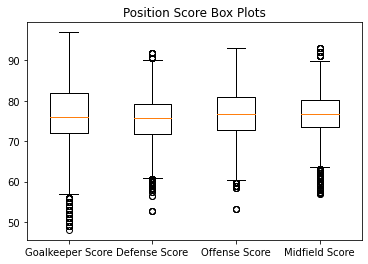

In [207]:
def draw_position_box_plots(df):
    position_scores = gather_position_scores(df)
    pos_names = [
    'gk_score',
    'def_score',
    'atk_score',
    'mid_score'
    ]

    pos_names = [
        'Goalkeeper Score',
        'Defense Score',
        'Offense Score',
        'Midfield Score'
    ]

    #drawing one by one
    for i in range(len(pos_names)):
        draw_box_plot(position_scores[i], pos_names[i])
    
    #drawing all in same graph
    plot_data = pd.DataFrame({
        'Goalkeeper Score' : position_scores[0][:10554],
        'Defense Score' : position_scores[1][:10554],
        'Offense Score' : position_scores[2][:10554],
        'Midfield Score' : position_scores[3][:10554]
    })

    my_dict = {
        'Goalkeeper Score' : position_scores[0][:10554],
        'Defense Score' : position_scores[1][:10554],
        'Offense Score' : position_scores[2][:10554],
        'Midfield Score' : position_scores[3][:10554]
    }
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    ax.set_title('Position Score Box Plots')

draw_position_box_plots(g_df)


## 4. Feature Engineering

### 4.1 Position Score Averages

In [208]:
def fill_score_average_record(record, df, index):
    #countries in this record

    home_score = [
    'home_team_goalkeeper_score', 
    'home_team_mean_defense_score', 
    'home_team_mean_offense_score',
    'home_team_mean_midfield_score',
    ]

    away_score = [
    'away_team_goalkeeper_score',
    'away_team_mean_defense_score',
    'away_team_mean_offense_score', 
    'away_team_mean_midfield_score',
    ]

    home_total = 0
    away_total = 0

    for feature in home_score:
        home_total += record[feature]
    for feature in away_score:
        away_total += record[feature]
    
    home_total /= len(home_score)
    away_total /= len(away_score)

    #print(home_total, away_total)

    df.at[index, 'home_team_total_average'] = home_total
    df.at[index, 'away_team_total_average'] = away_total

In [209]:
def create_score_averages(df):
    #first, create the new column for home advantage feature
    df['home_team_total_average'] = ''
    df['away_team_total_average'] = ''
    for index, record in df.iterrows():
        fill_score_average_record(record, df, index)


### 4.2 Goal Difference

In [210]:
def fill_goal_difference_record(record, df, index):
    #countries in this record

    home_goals = record['home_team_score']
    away_goals = record['away_team_score']
    goal_diff = abs(home_goals - away_goals)

    df.at[index, 'goal_difference'] = goal_diff

In [211]:
def create_goal_differences(df):
    #first, create the new column for home score difference feature
    df['goal_difference'] = ''
    for index, record in df.iterrows():
        fill_goal_difference_record(record, df, index)
    del df['home_team_score']
    del df['away_team_score']

### 4.3 Rank Difference

In [212]:
def fill_rank_difference_record(record, df, index):
    #countries in this record

    home_rank = record['home_team_fifa_rank']
    away_rank = record['away_team_fifa_rank']
    rank_diff = home_rank - away_rank

    #print(rank_diff)

    df.at[index, 'home_team_rank_difference'] = rank_diff

In [213]:
def create_rank_differences(df):
    #first, create the new column for home rank difference feature
    df['home_team_rank_difference'] = ''
    for index, record in df.iterrows():
        fill_rank_difference_record(record, df, index)

### 4.4 Export DataFrame to CSV

In [214]:
def export_csv(df, name):
    filename = name + ".csv"
    df.to_csv(filename)

create_score_averages(g_df)
create_goal_differences(g_df)
create_rank_differences(g_df)
g_df.to_csv(NEW_FEATURES_GAUSSIAN_MATCH_HISTORY)

i_df = pd.read_csv(INTERPOLATED_MATCH_HISTORY)
create_score_averages(i_df)
create_goal_differences(i_df)
create_rank_differences(i_df)
i_df.to_csv(NEW_FEATURES_INTERPOLATED_MATCH_HISTORY)

r_df = pd.read_csv(LINEAR_REGRESSION_MATCH_HISTORY)
create_score_averages(r_df)
create_rank_differences(r_df)
r_df.to_csv(NEW_FEATURES_LINEAR_REGRESSION_MATCH_HISTORY)


KeyError: 'home_team_score'

## **4. Methodology Overview**

"Start by describing in broad terms your methodology. Include any background reading you may have done and a step by step description of how you have trained and evaluated your model. Describe any feature engineering that you have applied. If you had attempted different approaches prior to landing on your final methodology, then describe those approaches here."

*Code for the equivalent section in your report, together with in-line documentation of that code.*

In [ ]:
#Code blocks testing each method?
#More code blocks displaying results of experiments?

## **5. Model Training & Validation**

"This contains a breakdown of how your model was trained and evaluated."

*Code for the equivalent section in your report, together with in-line documentation of that code.*

## SVM Model Trainer and Confusion Matrix

In [ ]:
def train_svm_model(x_train, y_train, x_test, y_test):
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='poly')).fit(x_train, y_train)
    svm_predictions = svm_model.predict(x_test)

    svm_cm = confusion_matrix(y_test, svm_predictions, labels=svm_model.classes_)
    return (svm_model, svm_predictions, svm_cm)

## Logistic Regression Trainer and Confusion Matrix

In [ ]:
def train_lr_model(x_train, y_train, x_test, y_test):
    lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000).fit(x_train, y_train)
    lr_predictions = lr_model.predict(x_test)

    lr_cm = confusion_matrix(y_test, lr_predictions, labels=lr_model.classes_)
    return (lr_model, lr_predictions, lr_cm)

## Multi Layer Perceptron Trainer and Confusion Matrix

In [ ]:
def train_mlp_model(x_train, y_train, x_test, y_test):
    mlp_model = MLPClassifier(random_state=1, max_iter=10000).fit(x_train, y_train)
    mlp_predictions = mlp_model.predict(x_test)

    mlp_cm = confusion_matrix(y_test, mlp_predictions, labels=mlp_model.classes_)
    return (mlp_model, mlp_predictions, mlp_cm)

## k-Nearest Neighbour Trainer and Confusion Matrix

In [ ]:
def train_knn_model(x_train, y_train, x_test, y_test):
    knn_model = KNeighborsClassifier(n_neighbors=40).fit(x_train, y_train)
    knn_predictions = knn_model.predict(x_test)

    knn_cm = confusion_matrix(y_test, knn_predictions, labels=knn_model.classes_)
    return (knn_model, knn_predictions, knn_cm)

## Data Preporation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

ACTIVE_FEATURES = ['home_team_fifa_rank', 'away_team_fifa_rank',
                       'home_team_result',
                       'home_team_goalkeeper_score',
                       'away_team_goalkeeper_score',
                       'home_team_mean_defense_score',
                       'home_team_mean_offense_score',
                       'home_team_mean_midfield_score',
                       'away_team_mean_defense_score',
                       'away_team_mean_offense_score',
                       'away_team_mean_midfield_score',
                       'home_team_total_average','away_team_total_average',
                       'goal_difference','home_team_rank_difference']

def prep_data(file_name: str) -> tuple:
    dataset = pd.read_csv(file_name)
    dataset = dataset.replace(['Lose', 'Draw', 'Win'], [-1, 0, 1])
    dataset = dataset.select_dtypes([np.number])

    for column in dataset.columns:
        if column not in ACTIVE_FEATURES:
            dataset = dataset.copy().drop([column], axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(dataset.copy().drop(['home_team_result'],axis=1), dataset['home_team_result'], test_size=0.2)
    return (x_train, x_test, y_train, y_test)

## Training Models and Printing Results

INTERPOLATED_MATCH_HISTORY:
    SVM Predictions: 51.6386182462356 
        SVM F1 Score: 0.35914202824600355
        SVM Precision Score: 0.4020599394964877
        SVM Recall Score: 0.4137565778476566


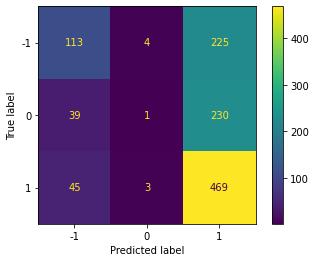

    LR Predictions: 54.56155890168291 
        LR F1 Score: 0.40174520484708287
        LR Precision Score: 0.6919910699300784
        LR Recall Score: 0.45911686228968795


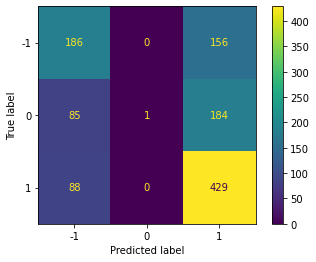

    KNN Predictions: 52.96722763507529 
        KNN F1 Score: 0.41770475198472745
        KNN Precision Score: 0.4423299576240753
        KNN Recall Score: 0.4529397496176146


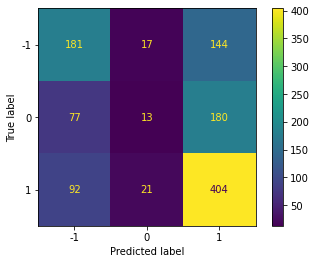

    MLP Predictions: 52.79007971656333 
        MLP F1 Score: 0.43727903217395836
        MLP Precision Score: 0.44369773853718186
        MLP Recall Score: 0.4652065007421484


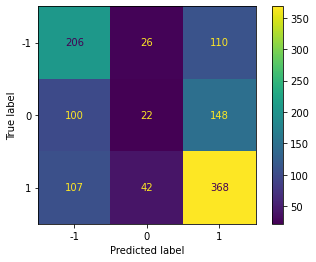


LINEAR_REGRESSION_MATCH_HISTORY:
    SVM Predictions: 51.72719220549159 
        SVM F1 Score: 0.34562998877267254
        SVM Precision Score: 0.516740580675151
        SVM Recall Score: 0.40417792728039403


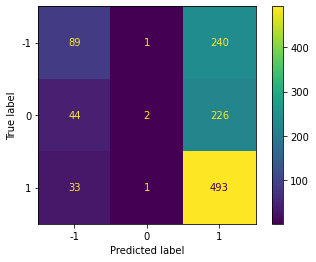

    LR Predictions: 56.59875996457041 
        LR F1 Score: 0.4117542399459602
        LR Precision Score: 0.3698674270478448
        LR Recall Score: 0.4725183524045004


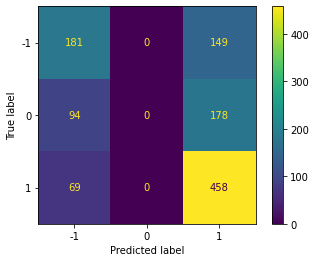

    KNN Predictions: 53.14437555358724 
        KNN F1 Score: 0.39936664886176326
        KNN Precision Score: 0.3858691585397878
        KNN Recall Score: 0.4460688478715044


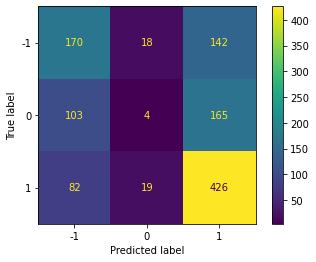

    MLP Predictions: 54.207263064658996 
        MLP F1 Score: 0.42533279609539526
        MLP Precision Score: 0.45747065949667537
        MLP Recall Score: 0.4529517183217373


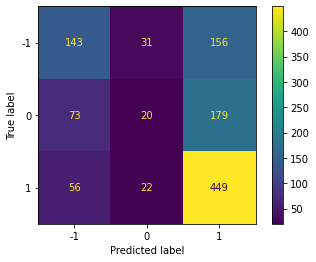


NEW_FEATURE_INTERPOLATED_MATCH_HISTORY:
    SVM Predictions: 70.59344552701505 
        SVM F1 Score: 0.6891305436527353
        SVM Precision Score: 0.7575131152298648
        SVM Recall Score: 0.679837940458229


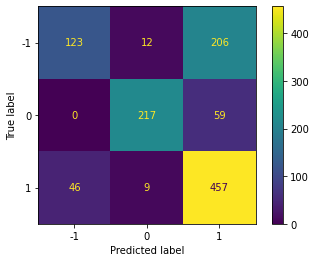

    LR Predictions: 79.71656333038086 
        LR F1 Score: 0.8009749354631429
        LR Precision Score: 0.8054884298154489
        LR Recall Score: 0.8035725195503421


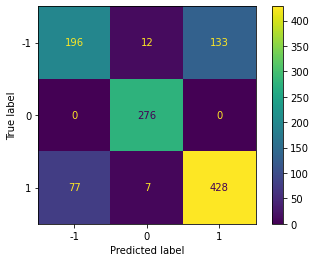

    KNN Predictions: 54.56155890168291 
        KNN F1 Score: 0.42796923106785983
        KNN Precision Score: 0.44501763176784603
        KNN Recall Score: 0.47157715722264726


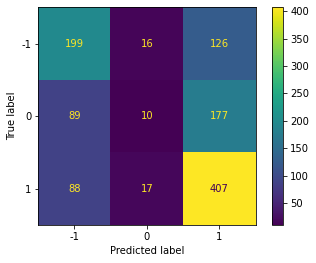

    MLP Predictions: 79.45084145261293 
        MLP F1 Score: 0.8008835336360397
        MLP Precision Score: 0.8011072505953053
        MLP Recall Score: 0.8037707733453043


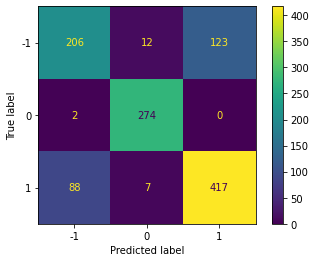


NEW_FEATURE_LINEAR_REGRESSION_MATCH_HISTORY:
    SVM Predictions: 50.31000885739593 
        SVM F1 Score: 0.34405360197604723
        SVM Precision Score: 0.5093105008527374
        SVM Recall Score: 0.40277009894651417


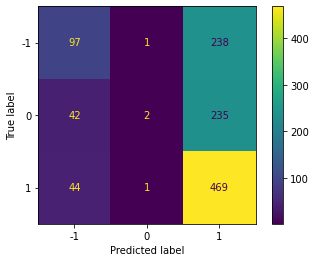

    LR Predictions: 54.738706820194864 
        LR F1 Score: 0.40440708434851924
        LR Precision Score: 0.3635871644151873
        LR Recall Score: 0.4650230066086098


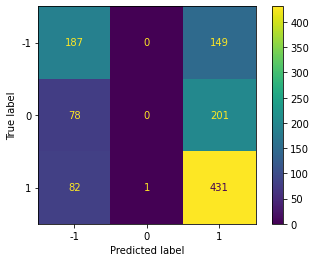

    KNN Predictions: 51.815766164747565 
        KNN F1 Score: 0.39647452775182507
        KNN Precision Score: 0.4137430362160612
        KNN Recall Score: 0.44263610043546026


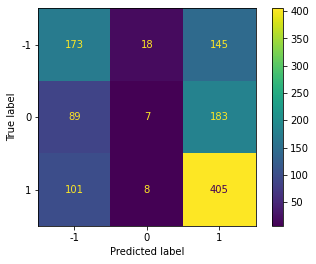

    MLP Predictions: 53.14437555358724 
        MLP F1 Score: 0.4516008351802719
        MLP Precision Score: 0.47530057944928633
        MLP Recall Score: 0.4622059547219582


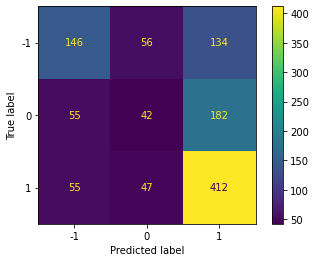


NEW_FEATURE_GAUSSIAN_MATCH_HISTORY:
    SVM Predictions: 68.11337466784765 
        SVM F1 Score: 0.6335936795487109
        SVM Precision Score: 0.7463712876249392
        SVM Recall Score: 0.6310364922433888


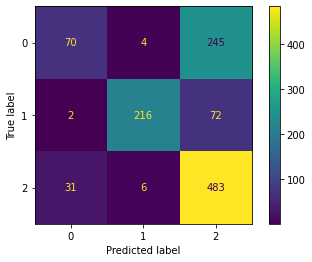

    LR Predictions: 78.56510186005315 
        LR F1 Score: 0.7778147793675744
        LR Precision Score: 0.794762555125648
        LR Recall Score: 0.777419419660799


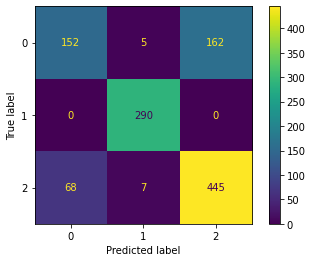

    KNN Predictions: 53.498671390611165 
        KNN F1 Score: 0.41560421818032384
        KNN Precision Score: 0.46870654949283724
        KNN Recall Score: 0.46002933847761435


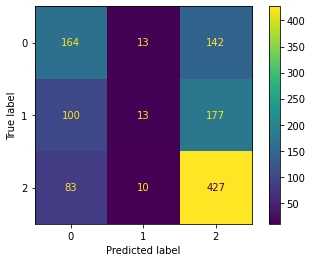

    MLP Predictions: 76.35075287865367 
        MLP F1 Score: 0.7805869693949766
        MLP Precision Score: 0.7807617410909415
        MLP Recall Score: 0.7924805079977494


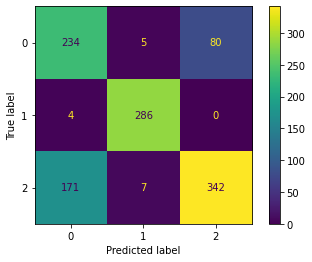

In [ ]:
DATASETS = {'INTERPOLATED_MATCH_HISTORY': '../dataset/reconstructed/interpolated_match_history.csv',
'LINEAR_REGRESSION_MATCH_HISTORY': '../dataset/reconstructed/linear_regression_match_history.csv',
'NEW_FEATURE_INTERPOLATED_MATCH_HISTORY': '../dataset/reconstructed/new_features_interpolated_match_history.csv',
'NEW_FEATURE_LINEAR_REGRESSION_MATCH_HISTORY': '../dataset/reconstructed/new_features_linear_regression_match_history.csv',
'NEW_FEATURE_GAUSSIAN_MATCH_HISTORY': '../dataset/reconstructed/new_features_gaussian_match_history.csv'}
%matplotlib inline
for method, file_name in DATASETS.items():
        print(f'\033[91m{method}:\033[0m')
        x_train, x_test, y_train, y_test = prep_data(file_name)
        models = {'SVM': train_svm_model, 'LR': train_lr_model, 'KNN': train_knn_model, 'MLP': train_mlp_model}
        for model_type, func in models.items():
            model, predictions, cm = func(x_train, y_train, x_test, y_test)
            print(f'\033[96m    {model_type} Predictions: {np.mean(predictions == y_test.values)*100} \033[0m')
            print(f'\033[93m        {model_type} F1 Score: {str(f1_score(y_test, predictions, average="macro", zero_division=0))}\033[0m')
            print(f'\033[93m        {model_type} Precision Score: {str(precision_score(y_test, predictions, average="macro", zero_division=0))}\033[0m')
            print(f'\033[93m        {model_type} Recall Score: {recall_score(y_test, predictions, average="macro", zero_division=0)}\033[0m')
            
            cm_disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
            cm_disp.plot()
            plt.show()
        print('')

## **6. Results**

"Here you show the results that you obtain using your model on the training data. If you have multiple variations or approaches, this is where you compare them."

*Code for the equivalent section in your report, together with in-line documentation of that code.*

In [ ]:
#Code for data visualisations of results

## **7. Final Predictions on Test Set**

"This is the section where you perform your final predictions on the test set using the model that you have trained in the previous section."

*Code for the equivalent section in your report, together with in-line documentation of that code.*

In [ ]:
#Code for performing the final prediction

## Credits

(Alphabetical ordering is my weakness...)

Minyong Cheong
<br>
Justin Koo
<br>
Adel Mouffok
<br>
James Parkington
<br>
Chris Sim
<br>
Angellika Vojevodina